## Imports

In [2]:
import qiskit
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import random
import math

from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.primitives import Sampler

from scipy.spatial.distance import jensenshannon
from pprint import pprint

## Loading in dataset

Loading in MNIST dataset

In [3]:
mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

class_arrays = [[] for _ in range(10)]

for image, label in zip(train_images, train_labels):
    class_arrays[label].append(image)

class_arrays = [tf.convert_to_tensor(images) for images in class_arrays]

for i, class_array in enumerate(class_arrays):
    print(f"Class {i} has {class_array.shape[0]} images.")

Class 0 has 5923 images.
Class 1 has 6742 images.
Class 2 has 5958 images.
Class 3 has 6131 images.
Class 4 has 5842 images.
Class 5 has 5421 images.
Class 6 has 5918 images.
Class 7 has 6265 images.
Class 8 has 5851 images.
Class 9 has 5949 images.


## Processing data

In this section we process all the classes to find out characteristic pixels based to that class.
The approach:
1. Convert the data into 1 and 0 values.
    - If a pixel value is <= 0.25, the pixel value is turned to 0
    - If a pixel value is >= 0.75, the pixel value is turned to 1
    - For every other case: take neighboring pixels, sum them and take the average. Based on the average determine if it will be 0 or 1.
2. Sum all the pixels and find the most repeating pixels. Top 5 pixels will be chosen as characteristic for that image.
3. Turn top 5 pixel indices into binary for grover's algorithm.
4. Because all pixels are top pixels, we also append at the end of the binary number a '1'. Giving us in the end a 9 bit binary value.

In [4]:
def process_class(class_array):
    new_array = []
    for image in class_array:
        image = image.numpy() / 255.0

        image = scipy.ndimage.zoom(image, (0.5, 0.5))

        image = np.where(image > 0.75, 1, image)
        image = np.where(image < 0.25, 0, image)

        padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)
        
        neighbors_sum = (
            padded_image[:-2, :-2] + padded_image[1:-1, :-2] + padded_image[2:, :-2] +
            padded_image[:-2, 1:-1] + padded_image[1:-1, 1:-1] + padded_image[2:, 1:-1] +
            padded_image[:-2, 2:] + padded_image[1:-1, 2:] + padded_image[2:, 2:]
        )

        average = neighbors_sum / 9

        mask = (image <= 0.75) & (image >= 0.25)

        image = np.where((image <= 0.75) & (image >= 0.25), 0, image)

        filtered_array = np.where(mask, average, 0)

        filtered_array = np.where(filtered_array > 0.6, 1, filtered_array)
        filtered_array = np.where(filtered_array <= 0.6, 0, filtered_array)


        image = np.where(filtered_array == 1, 1, image)

        new_array.append(image)

    return new_array

processed_images = [
    process_class(class_arrays[0]),
    process_class(class_arrays[1]),
    process_class(class_arrays[2]),
    process_class(class_arrays[3]),
    process_class(class_arrays[4]),
    process_class(class_arrays[5]),
    process_class(class_arrays[6]),
    process_class(class_arrays[7]),
    process_class(class_arrays[8]),
    process_class(class_arrays[9]),
]


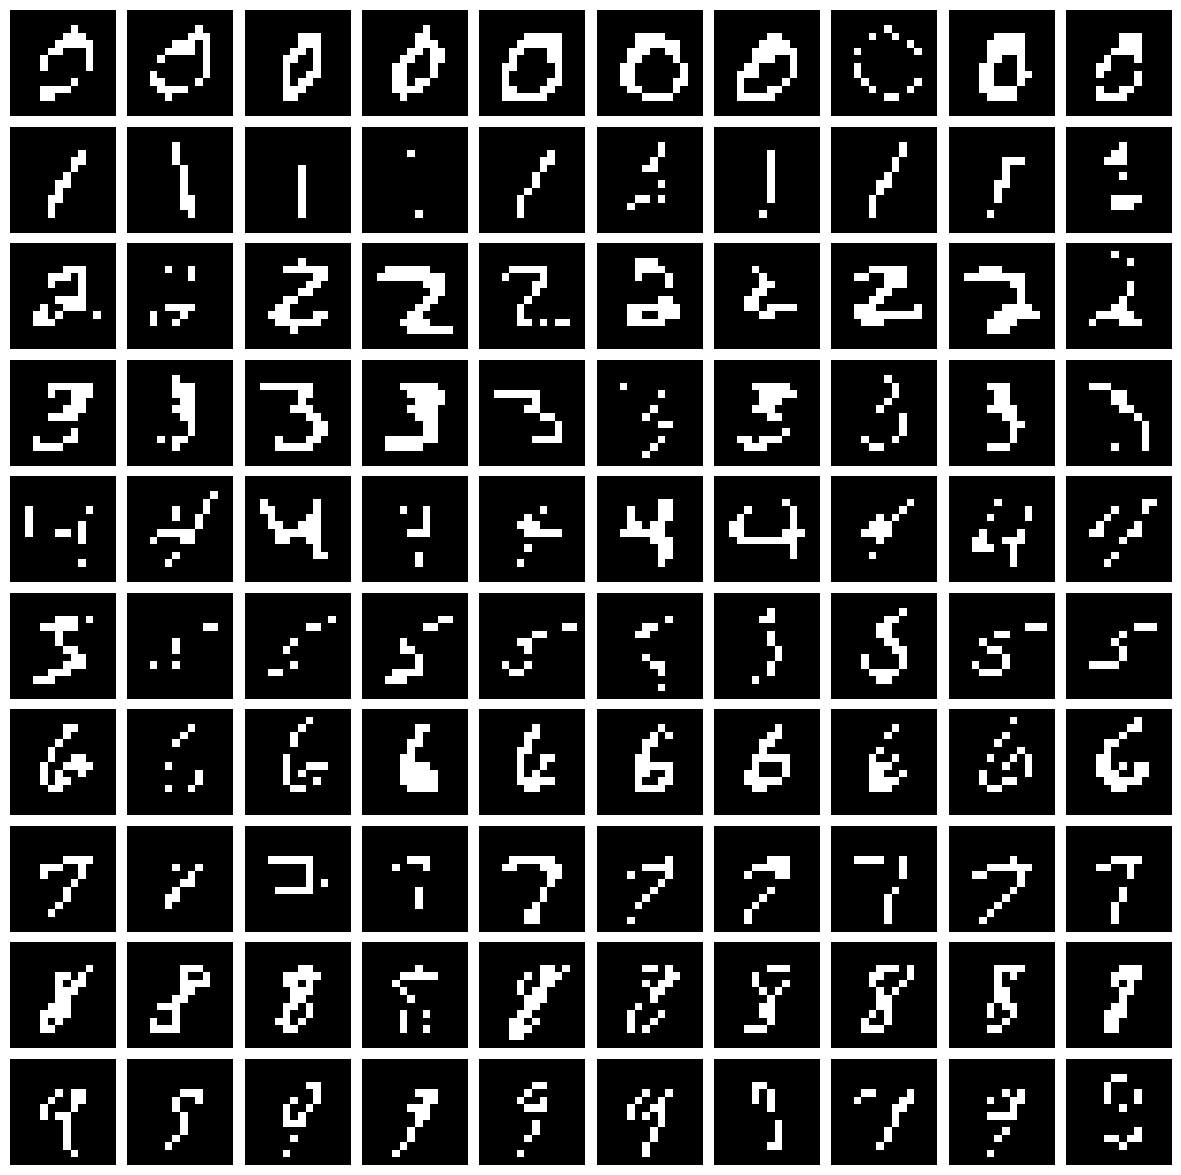

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for j in range(10):
        ax = axes[i, j]
        ax.imshow(processed_images[i][j], cmap='gray')
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Converting to binary

Converting each top pixel index to a 9 bit binary number

In [6]:
top_pixels = []

for images in processed_images:
    summed_images = np.sum(images, axis=0)

    flat_indices = np.argsort(summed_images, axis=None)[-10:]

    top_pixels.append(flat_indices.tolist())

pprint(top_pixels)

[[75, 130, 146, 62, 65, 147, 144, 49, 145, 50],
 [133, 146, 64, 63, 119, 132, 118, 77, 105, 91],
 [144, 130, 50, 49, 145, 133, 131, 118, 119, 132],
 [159, 148, 78, 92, 50, 160, 90, 48, 49, 91],
 [89, 104, 88, 92, 105, 103, 120, 102, 119, 106],
 [148, 147, 49, 50, 76, 62, 160, 75, 90, 89],
 [89, 118, 103, 133, 134, 117, 147, 132, 146, 131],
 [65, 133, 92, 61, 78, 79, 62, 106, 63, 64],
 [119, 90, 91, 92, 50, 49, 118, 160, 104, 105],
 [79, 63, 64, 119, 75, 120, 105, 62, 92, 106]]


In [7]:
binary_top_pixels = [[format(index, '08b') + '1' for index in sublist] for sublist in top_pixels]

pprint(binary_top_pixels)

[['010010111',
  '100000101',
  '100100101',
  '001111101',
  '010000011',
  '100100111',
  '100100001',
  '001100011',
  '100100011',
  '001100101'],
 ['100001011',
  '100100101',
  '010000001',
  '001111111',
  '011101111',
  '100001001',
  '011101101',
  '010011011',
  '011010011',
  '010110111'],
 ['100100001',
  '100000101',
  '001100101',
  '001100011',
  '100100011',
  '100001011',
  '100000111',
  '011101101',
  '011101111',
  '100001001'],
 ['100111111',
  '100101001',
  '010011101',
  '010111001',
  '001100101',
  '101000001',
  '010110101',
  '001100001',
  '001100011',
  '010110111'],
 ['010110011',
  '011010001',
  '010110001',
  '010111001',
  '011010011',
  '011001111',
  '011110001',
  '011001101',
  '011101111',
  '011010101'],
 ['100101001',
  '100100111',
  '001100011',
  '001100101',
  '010011001',
  '001111101',
  '101000001',
  '010010111',
  '010110101',
  '010110011'],
 ['010110011',
  '011101101',
  '011001111',
  '100001011',
  '100001101',
  '011101011',
  '1

## Grover's algorithm

Now wew construct grovers algorithm. We create grover operators for each class.

In [8]:
def grover_oracle(binary_states):
    if not isinstance(binary_states, list):
        binary_states = [binary_states]

    num_qubits = len(binary_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in binary_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        if len(zero_inds)>0:
            qc.x(zero_inds)
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
            qc.x(zero_inds)
        else:
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
    return qc

In [9]:
grover_oracles = []

for states in binary_top_pixels:
    oracle = grover_oracle(states)

    grover_op = GroverOperator(oracle)
    grover_oracles.append(grover_op)


In [10]:
for grover_op in grover_oracles:
    optimal_num_iterations = math.floor(
        math.pi / 4 * math.sqrt(2**grover_op.num_qubits / 10)
    )
    print(optimal_num_iterations)

5
5
5
5
5
5
5
5
5
5


## Trying it out

Need to give image, that has been processed, go through each oracle with 5 pixels and find which operator returns best match.

Here we are finding each distribution of all the classes of correct pixels.

In [ ]:
quasi_distributions = []

for grover_op in grover_oracles:
    U = Operator(oracle)

    optimal_num_iterations = math.floor(
        math.pi / 4 * math.sqrt(2**oracle.num_qubits / 10)
    )

    qc = QuantumCircuit(grover_op.num_qubits)
    qc.h(range(grover_op.num_qubits))
    qc.compose(grover_op.power(8), inplace=True)
    qc.measure_all()

    sampler = Sampler()

    result = sampler.run(qc).result()
    quasi_dists = result.quasi_dists

    quasi_distributions.append(quasi_dists)

## Ploting out the distributions

Example of the probabilities oracle has returned. We can chec the indices with binary values that were fed to validate the results.

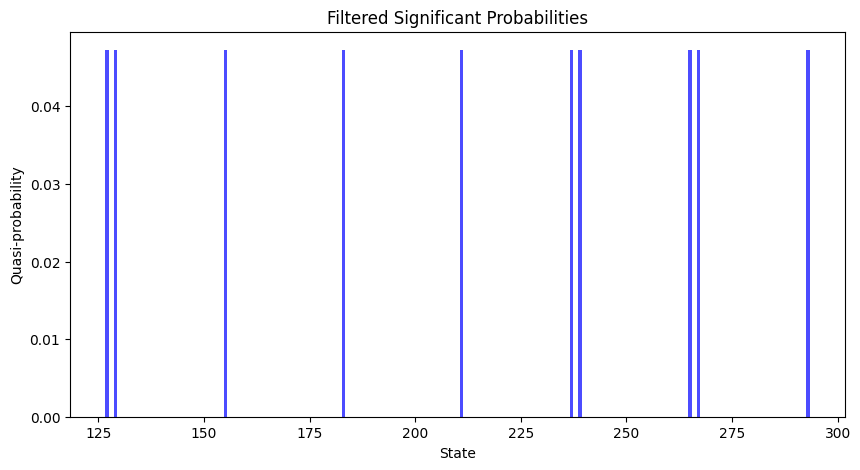

Filtered Significant Probabilities:
State: 239, Probability: 0.0472583451446856
State: 237, Probability: 0.0472583451446849
State: 183, Probability: 0.0472583451446847
State: 155, Probability: 0.0472583451446839
State: 129, Probability: 0.0472583451446833
State: 211, Probability: 0.0472583451446807
State: 293, Probability: 0.0472583451446803
State: 267, Probability: 0.0472583451446797
State: 127, Probability: 0.0472583451446795
State: 265, Probability: 0.0472583451446786


In [11]:
threshold = 0.04
filtered_dist = {k: v for k, v in quasi_distributions[1][0].items() if v > threshold}

filtered_dist = dict(sorted(filtered_dist.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 5))
plt.bar(filtered_dist.keys(), filtered_dist.values(), color='blue', alpha=0.7)
plt.xlabel('State')
plt.ylabel('Quasi-probability')
plt.title('Filtered Significant Probabilities')
plt.show()

print("Filtered Significant Probabilities:")
for state, prob in filtered_dist.items():
    print(f"State: {state}, Probability: {prob}")

## Classifying an image

Let's take a random image from MNIST to figure out what class it is.

Random processed image of class: 8, at position 1036.


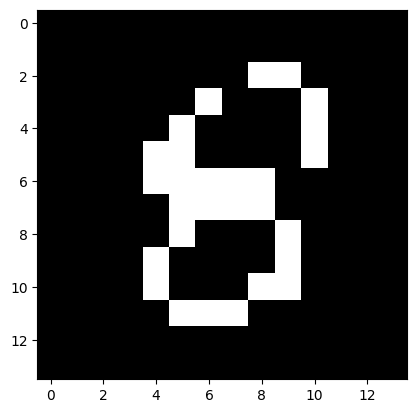

In [13]:
random_class = random.randint(0, 9)
random_indice = random.randint(1000, 5000)

random_image = processed_images[random_class][random_indice]

print(f"Random processed image of class: {random_class}, at position {random_indice}.")
plt.imshow(random_image, cmap='gray')
plt.show()

We now want to go through each class pixel locations and compare results with the actuall distributions. Highest value will be deemed to be most accurate prediction.

Firstly we take top pixels of each class. Based on the pixel value we apped either a '0' or a '1' to the binary value. 

In [14]:
flattened_image = [pixel for row in random_image for pixel in row]

random_image_binary = [[format(index, '08b') for index in sublist] for sublist in top_pixels]
random_image_binary_filtered = []

for class_indices, class_binary in zip(top_pixels, random_image_binary):
    temp = []
    for indice, binary in zip(class_indices, class_binary):
        binary = binary + str(int(flattened_image[indice]))
        temp.append(binary)
    random_image_binary_filtered.append(temp)
pprint(random_image_binary_filtered)

[['010010111',
  '100000101',
  '100100100',
  '001111100',
  '010000010',
  '100100110',
  '100100001',
  '001100010',
  '100100010',
  '001100100'],
 ['100001010',
  '100100100',
  '010000000',
  '001111110',
  '011101110',
  '100001000',
  '011101100',
  '010011010',
  '011010011',
  '010110111'],
 ['100100001',
  '100000101',
  '001100100',
  '001100010',
  '100100010',
  '100001010',
  '100000110',
  '011101100',
  '011101110',
  '100001000'],
 ['100111111',
  '100101001',
  '010011100',
  '010111001',
  '001100100',
  '101000001',
  '010110101',
  '001100001',
  '001100010',
  '010110111'],
 ['010110011',
  '011010001',
  '010110001',
  '010111001',
  '011010011',
  '011001111',
  '011110000',
  '011001100',
  '011101110',
  '011010101'],
 ['100101001',
  '100100110',
  '001100010',
  '001100100',
  '010011000',
  '001111100',
  '101000001',
  '010010111',
  '010110101',
  '010110011'],
 ['010110011',
  '011101100',
  '011001111',
  '100001010',
  '100001100',
  '011101011',
  '1

Now we create grover operators for each class and run distributions

In [15]:
random_image_quasi_distributions = []
random_image_grover_oracles = []

for states in random_image_binary_filtered:
    oracle = grover_oracle(states)

    grover_op = GroverOperator(oracle)
    random_image_grover_oracles.append(grover_op)


for grover_op in random_image_grover_oracles:
    optimal_num_iterations = math.floor(
        math.pi / 4 * math.sqrt(2**oracle.num_qubits / 5)
    )

    qc = QuantumCircuit(grover_op.num_qubits)
    qc.h(range(grover_op.num_qubits))
    qc.compose(grover_op.power(8), inplace=True)
    qc.measure_all()

    sampler = Sampler()

    result = sampler.run(qc).result()
    quasi_dists = result.quasi_dists

    random_image_quasi_distributions.append(quasi_dists)

## Making the prediction

Having both distributions, using Jensen-Shannon Divergence, we can check how much top pixels diverge from actual values. The lower the number - higher the chance of that class being correct one.

- 0 value represents an identical match
- 0.99 value represents that no values match

Based on that we make a prediction.

In [16]:
for i in range(10):
    real_distributions = quasi_distributions[i][0]
    predicted_distributions = random_image_quasi_distributions[i][0]

    # Convert dictionaries to numpy arrays
    keys = sorted(real_distributions.keys())
    p = np.array([real_distributions[key] for key in keys])
    q = np.array([predicted_distributions[key] for key in keys])

    # Compute Jensen-Shannon Divergence
    js_divergence = jensenshannon(p, q, base=2)

    print(f"{i} Jensen-Shannon Divergence: {js_divergence}")

0 Jensen-Shannon Divergence: 0.5357711375185169
1 Jensen-Shannon Divergence: 0.5727634383761238
2 Jensen-Shannon Divergence: 0.5727634383761223
3 Jensen-Shannon Divergence: 0.3507445418358881
4 Jensen-Shannon Divergence: 0.3507445418358835
5 Jensen-Shannon Divergence: 0.4528092564345166
6 Jensen-Shannon Divergence: 0.5357711375185239
7 Jensen-Shannon Divergence: 0.5357711375185213
8 Jensen-Shannon Divergence: 0.4050049112914789
9 Jensen-Shannon Divergence: 0.49602768799264346


## Prediction loop

In [44]:
def get_random_image():
    random_class = random.randint(0, 9)
    random_indice = random.randint(1000, 5000)

    random_image = processed_images[random_class][random_indice]

    print(f"Random processed image of class: {random_class}, at position {random_indice}.")
    return random_image, random_class

def get_image_binary(image, top_pixels):
    flattened_image = [pixel for row in image for pixel in row]

    random_image_binary = [[format(index, '08b') for index in sublist] for sublist in top_pixels]
    random_image_binary_filtered = []

    for class_indices, class_binary in zip(top_pixels, random_image_binary):
        temp = []
        for indice, binary in zip(class_indices, class_binary):
            binary = binary + str(int(flattened_image[indice]))
            temp.append(binary)
        random_image_binary_filtered.append(temp)

    return random_image_binary_filtered

def get_grover_operators(binary_states):
    grover_oracles = []

    for states in binary_states:
        oracle = grover_oracle(states)

        grover_op = GroverOperator(oracle)
        grover_oracles.append(grover_op)

    return grover_oracles

def get_image_quasi_distributions():
    random_image, random_image_class = get_random_image()
    random_image_binary = get_image_binary(random_image, top_pixels)

    random_image_quasi_distributions = []

    grover_operators = get_grover_operators(random_image_binary)

    for grover_op in grover_operators:
        optimal_num_iterations = math.floor(
            math.pi / 4 * math.sqrt(2**oracle.num_qubits / 5)
        )

        qc = QuantumCircuit(grover_op.num_qubits)
        qc.h(range(grover_op.num_qubits))
        qc.compose(grover_op.power(8), inplace=True)
        qc.measure_all()

        sampler = Sampler()

        result = sampler.run(qc).result()
        quasi_dists = result.quasi_dists

        random_image_quasi_distributions.append(quasi_dists)

    return random_image_quasi_distributions, random_image_class

def get_jensen_shannon_divergence(quasi_distributions, new_image_quasi_distributions):
    js_divergences = []

    for i in range(10):
        first = quasi_distributions[i][0]
        second = new_image_quasi_distributions[i][0]

        keys = sorted(first.keys())
        p = np.array([first[key] for key in keys])
        q = np.array([second[key] for key in keys])

        js_divergence = jensenshannon(p, q, base=2)

        js_divergences.append(js_divergence)

    return js_divergences

def get_prediction(js_distributions):
    return js_distributions.index(min(js_distributions))

In [48]:
correct_predictions = 0

for i in range(10):
    distributions, correct_class = get_image_quasi_distributions()
    js = get_jensen_shannon_divergence(quasi_distributions, distributions)

    predicted_class = get_prediction(js)

    print(f"Predicted class: {predicted_class}, actuall class: {correct_class}")

    if predicted_class == correct_class:
        correct_predictions = correct_predictions + 1

    if correct_predictions != 0 and i != 0:
        print(f"Prediction accuracy: {correct_predictions / (i + 1)}")
    

Random processed image of class: 9, at position 2617.
Predicted class: 7, actuall class: 9
Random processed image of class: 6, at position 4172.
Predicted class: 6, actuall class: 6
Prediction accuracy: 0.5
Random processed image of class: 0, at position 4265.
Predicted class: 0, actuall class: 0
Prediction accuracy: 0.6666666666666666
Random processed image of class: 8, at position 3517.
Predicted class: 4, actuall class: 8
Prediction accuracy: 0.5
Random processed image of class: 8, at position 1389.
Predicted class: 1, actuall class: 8
Prediction accuracy: 0.4
Random processed image of class: 0, at position 4253.
Predicted class: 2, actuall class: 0
Prediction accuracy: 0.3333333333333333
Random processed image of class: 0, at position 1866.
Predicted class: 0, actuall class: 0
Prediction accuracy: 0.42857142857142855
Random processed image of class: 3, at position 4177.
Predicted class: 3, actuall class: 3
Prediction accuracy: 0.5
Random processed image of class: 4, at position 152